# Building confidence ellipses (in meters) for PyMC3 algorithm
### **Origin of the reference system: Projected 3D traveltime (Lower left corner)**

#### In the following code we will start building the confidence ellipses for our PyMC3 code. We only need the file **data/6_clusters/catalog_with_clusters_ids.csv** resulted from ConvNetQuake.

###### The *catalog_with_clusters_ids.csv* file is obtained afer run:
**./bin/preprocess/cluster_events.ridgcrest --src data/catalogs/Ridgecrest_filtrado.csv --dst data/6_clusters --n_components 6 --model KMeans**

In [1]:
#Importing libraries
import csv
import os
import json
import pandas as pd
from pyproj import Proj, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2

##### The original catalog is in decimal degrees (EPSG:4326). We need to transform this initial coordinate system to EPSG:32611, which is in meters and corresponds to the adequate projection system for our area of study. Moreover, it is neccessary to adjust the coordinate (0,0) to a relative reference system.

In [2]:
# Define the original coordinate system (latitude, longitude)
latlon_string = "+proj=latlong +datum=WGS84 +ellps=WGS84"
latlon = Proj(latlon_string)

# Define the target coordinate system (UTM in Zone 11, northern hemisphere, WGS84)
utm_string ="+proj=utm +zone=11 +datum=WGS84 +ellps=WGS84"
utm_s = Proj(utm_string)

# Define the coordinates of the station and the reference point
station_latitude = 35.81574
station_longitude = -117.59751
station_depth = -775.0 # Over the sea level
station_z = station_depth

# Coordinates of the reference point that will be used for defining the (0,0)
reference_latitude = 35.2
reference_longitude = -118.2
reference_depth = 0
ref_z = reference_depth

# Transform the coordinates of the station and the reference point to UTM
station_x, station_y = transform(latlon, utm_s, station_longitude, station_latitude)
ref_x, ref_y = transform(latlon, utm_s, reference_longitude, reference_latitude)

# Read data from the CSV file
csv_file = '/Users/cecilia/CONVN/data/6_clusters/catalog_with_cluster_ids.csv'
data = pd.read_csv(csv_file)

# Transform all coordinates to UTM and set the origin to the reference point
data['longitude_UTM'], data['latitude_UTM'] = transform(latlon, utm_s, data['longitude'].values, data['latitude'].values)
data['longitude_UTM'] -= ref_x
data['latitude_UTM'] -= ref_y

# Transform the 'depth' column from kilometers to meters
data['depth'] *= 1000  # 1 kilometer = 1000 meters

# Subtract the coordinates of the reference point from the station coordinates
station_x -= ref_x
station_y -= ref_y

# Print some rows of the resulting DataFrame
#print(data.head())

# Print the transformed station coordinates
#print(f'The transformed station coordinates are: {station_x}, {station_y}, {station_z}')

# Save the transformed data to a new CSV file
output_file = '/Users/cecilia/CONVN/data/6_clusters/catalog_with_cluster_ids_meters_3D_TT.csv'
data.to_csv(output_file, index=False)

# Define parameter for the .json file
projection_dict = {
    "latlon_string": latlon_string,
    "utm_string": utm_string,
    "Origin_reference": 'TT (lower left corner)',
    "ref_long": reference_longitude,
    "ref_lat": reference_latitude,
    "ref_depth": reference_depth,
    "ref_x_UTM": ref_x,
    "ref_y_UTM": ref_y,
    "ref_z_UTM": ref_z
}


# Specify .json file's name
file_name = "/Users/cecilia/CONVN/data/6_clusters/csv_clusters/3D_TT/projections_catalog_3D_TT.json"

# Save the dictionary in a json file
with open(file_name, "w") as json_file:
    json.dump(projection_dict, json_file)


/var/folders/6p/x1tfp6451svc9hvzk2kt63wr0000h1/T/ipykernel_37574/768140501.py:22: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  station_x, station_y = transform(latlon, utm_s, station_longitude, station_latitude)
/var/folders/6p/x1tfp6451svc9hvzk2kt63wr0000h1/T/ipykernel_37574/768140501.py:23: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ref_x, ref_y = transform(latlon, utm_s, reference_longitude, reference_latitude)
/var/folders/6p/x1tfp6451svc9hvzk2kt63wr0000h1/T/ipykernel_37574/768140501.py:30: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  data['longitude_UTM'], data['latitude_UTM'] = transform(latlon, utm_s, data['longitude'].values, data['latitude'].values)


In [3]:
# Define the path of the .csv file
file_path = '/Users/cecilia/CONVN/data/6_clusters/catalog_with_cluster_ids_meters_3D_TT.csv'

# Create a dictionary to store data for each cluster_id
data_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

# Read the .csv file and split the data into the dictionary based on cluster_id
with open(file_path, 'r') as file:
    csv_reader = csv.reader(file)
    headers = next(csv_reader)  # Read the file header
    for row in csv_reader:
        cluster_id = int(row[2])
        data_dict[cluster_id].append(row)

# Create a directory to store the files
output_dir = '/Users/cecilia/CONVN/data/6_clusters/csv_clusters/3D_TT'
os.makedirs(output_dir, exist_ok=True)

# Write the data to separate files based on cluster_id
for cluster_id, rows in data_dict.items():
    cluster_file_path = os.path.join(output_dir, f'cluster_{cluster_id}_meters.csv')
    with open(cluster_file_path, 'w', newline='') as cluster_file:
        csv_writer = csv.writer(cluster_file)
        csv_writer.writerow(headers)  # Write the header
        csv_writer.writerows(rows)

print("Separate files created successfully.")


Separate files created successfully.


##### Next, we will build the confidence ellipses for each *cluster_id* and plot the ellipses.

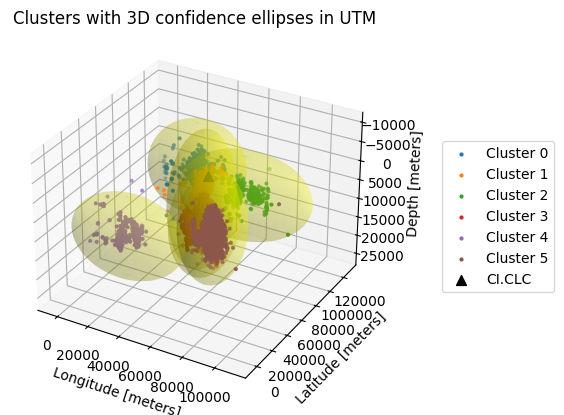

In [4]:
# Define a function to plot the confidence ellipse in 3D
def confidence_ellipse_3d(x, y, z, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size or x.size != z.size or y.size != z.size:
        raise ValueError("x, y, and z must be the same size")
    
    cov_matrix = np.cov(np.vstack((x, y, z)))

    # Extracting covariance values from the matrix
    cov_xy = cov_matrix[0, 1]
    cov_xz = cov_matrix[0, 2]
    cov_yz = cov_matrix[1, 2]

    # Calculate the correlation coefficients
    pearson_xy = cov_xy / np.sqrt(cov_matrix[0, 0] * cov_matrix[1, 1])
    pearson_xz = cov_xz / np.sqrt(cov_matrix[0, 0] * cov_matrix[2, 2])
    pearson_yz = cov_yz / np.sqrt(cov_matrix[1, 1] * cov_matrix[2, 2])

    # Calculate the angles of the ellipses
    theta_xy = 0.5 * np.arctan(2 * pearson_xy * cov_xy / (cov_matrix[0, 0] - cov_matrix[1, 1]))
    theta_xz = 0.5 * np.arctan(2 * pearson_xz * cov_xz / (cov_matrix[0, 0] - cov_matrix[2, 2]))
    theta_yz = 0.5 * np.arctan(2 * pearson_yz * cov_yz / (cov_matrix[1, 1] - cov_matrix[2, 2]))

    # Calculate the axes of the ellipses
    width = 2 * n_std * np.sqrt(cov_matrix[0, 0])
    height = 2 * n_std * np.sqrt(cov_matrix[1, 1])
    depth = 2 * n_std * np.sqrt(cov_matrix[2, 2])

    # Create a 3D ellipse using a wireframe plot
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_ellipse = np.mean(x) + width * np.outer(np.cos(u), np.sin(v))
    y_ellipse = np.mean(y) + height * np.outer(np.sin(u), np.sin(v))
    z_ellipse = np.mean(z) - depth * np.outer(np.ones(np.size(u)), np.cos(v))  # Invert the depth

    ax.plot_surface(x_ellipse, y_ellipse, z_ellipse, color=facecolor, alpha=0.2, **kwargs)

    return ax

# Create a 3D figure and a single set of axes
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Iterate over CSV files and display ellipses and points on the same 3D figure
for i in range(6):
    # Read the CSV file
    data = pd.read_csv(f'/Users/cecilia/CONVN/data/6_clusters/csv_clusters/3D_TT/cluster_{i}_meters.csv')

    # Extract columns of longitude, latitude, and depth
    x = data['longitude_UTM']
    y = data['latitude_UTM']
    z = data['depth']

    # Plot data points and confidence ellipse in 3D
    ax_3d.scatter(x, y, z, s=4, label=f'Cluster {i}')
    confidence_ellipse_3d(x, y, z, ax_3d, facecolor='yellow')

# Invert the depth axis by adjusting the limits
ax_3d.set_zlim(ax_3d.get_zlim()[::-1])

# Add station point in 3D
#ax_3d.scatter(station_x, station_y, 0, marker="^", color='black', s=50, label='CI.CLC')

# Add labels to axes and title
ax_3d.set_xlabel('Longitude [meters]')
ax_3d.set_ylabel('Latitude [meters]')
ax_3d.set_zlabel('Depth [meters]')
ax_3d.set_title('Clusters with 3D confidence ellipses in UTM')

# Add station point in 3D
ax_3d.scatter(station_x, station_y, station_z, marker="^", color='black', s=50, label='CI.CLC')

# Add legend to the right of the plot
legend_3d = ax_3d.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))

# Save the 3D plot in PNG format and make sure the legend is included
plt.grid(True)
plt.savefig('/Users/cecilia/CONVN/data/6_clusters/confidence_ellipses_ridgecrest_meters_3D_TT.png', format='png', bbox_inches='tight', bbox_extra_artists=[legend_3d])

# Show the 3D figure
plt.show()


#### Finally we will obtain the confidence ellipses information.

In [5]:
# Lists to store covariance matrices and means
cov_matrices_3D_TT = []
mus_3D_TT = []

# Iterate over CSV files
for i in range(6):
    # Read the CSV file
    data = pd.read_csv(f'/Users/cecilia/CONVN/data/6_clusters/csv_clusters/3D_TT/cluster_{i}_meters.csv')

    # Extract columns of longitude, latitude, and depth
    x = data['longitude_UTM']
    y = data['latitude_UTM']
    z = data['depth']

    # Calculate mean and covariance matrix
    mu = np.mean(x), np.mean(y), np.mean(z)
    cov = np.cov(np.vstack((x, y, z)))

    # Check if the covariance matrix is singular and, if necessary, regularize
    if np.linalg.det(cov) == 0:
        cov += 1e-10 * np.eye(3)  # Add a small amount to the diagonal to regularize

    # Append cov and mu to the lists
    cov_matrices_3D_TT.append(cov)
    mus_3D_TT.append(mu)

    # Calculate eigenvectors and eigenvalues
    eigvals, eigvecs = np.linalg.eig(cov)

    # Calculate orientation in degrees
    pearson_xy = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    pearson_xz = cov[0, 2] / np.sqrt(cov[0, 0] * cov[2, 2])
    pearson_yz = cov[1, 2] / np.sqrt(cov[1, 1] * cov[2, 2])

    theta_xy = 0.5 * np.arctan(2 * pearson_xy * cov[0, 1] / (cov[0, 0] - cov[1, 1]))
    theta_xz = 0.5 * np.arctan(2 * pearson_xz * cov[0, 2] / (cov[0, 0] - cov[2, 2]))
    theta_yz = 0.5 * np.arctan(2 * pearson_yz * cov[1, 2] / (cov[1, 1] - cov[2, 2]))

    orientation_degrees_xy = 180 * theta_xy / np.pi
    orientation_degrees_xz = 180 * theta_xz / np.pi
    orientation_degrees_yz = 180 * theta_yz / np.pi

    # Calculate standard deviations
    std_dev_x = np.sqrt(cov[0, 0])
    std_dev_y = np.sqrt(cov[1, 1])
    std_dev_z = np.sqrt(cov[2, 2])

    # Calculate 95% confidence ellipsoid
    confidence_level = 0.95
    rv = multivariate_normal(mean=mu, cov=cov)
    ell_radius_x = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_x
    ell_radius_y = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_y
    ell_radius_z = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_z

    # Calculate eccentricities using Singular Value Decomposition (SVD)
    _, s, _ = np.linalg.svd(cov)
    eccentricity_xy = np.sqrt(1 - (np.min(s[:2]) / np.max(s[:2]))**2)
    eccentricity_xz = np.sqrt(1 - (np.min(s[[0, 2]]) / np.max(s[[0, 2]]))**2)
    eccentricity_yz = np.sqrt(1 - (np.min(s[1:]) / np.max(s[1:]))**2)

    # In case of you need to print information
    print(f"\nCluster {i}:\n")
    print("Mean:", mu)
    print("Covariance matrix:\n", cov)
    #print("Eigenvalues:", eigvals)
    #print("Eigenvectors:\n", eigvecs)
    #print("Orientation (degrees):")
    #print("XY-plane:", orientation_degrees_xy)
    #print("XZ-plane:", orientation_degrees_xz)
    #print("YZ-plane:", orientation_degrees_yz)
    #print("Standard deviation in x:", std_dev_x)
    #print("Standard deviation in y:", std_dev_y)
    #print("Standard deviation in z:", std_dev_z)
    #print(f"Ellipsoid radius at {confidence_level * 100}% confidence:")
    #print("In x:", ell_radius_x)
    #print("In y:", ell_radius_y)
    #print("In z:", ell_radius_z)
    #print("Eccentricities:")
    #print("XY-plane:", eccentricity_xy)
    #print("XZ-plane:", eccentricity_xz)
    #print("YZ-plane:", eccentricity_yz)
    #print("\n---\n")

    # Convert NumPy matrices to lists
    cov_matrices_3D_TT_list = cov.tolist()
    eigvals_3D_TT_list = eigvals.tolist()
    eigvecs_3D_TT_list = eigvecs.tolist()

    # Create dictionary
    dictionary = {
    "Mean": mu,
    "Covariance": cov_matrices_3D_TT_list,
    "Eigenvalues": eigvals_3D_TT_list,
    "Eigenvectors": eigvecs_3D_TT_list,
    "OrientationXY": orientation_degrees_xy,
    "OrientationXZ": orientation_degrees_xz,
    "OrientationYZ": orientation_degrees_yz,
    "Standardx": std_dev_x,
    "Standardy": std_dev_y,
    "Standardz": std_dev_z,
    "Inx": ell_radius_x,
    "Iny": ell_radius_y,
    "Inz": ell_radius_z,
    "EccentricityXY": eccentricity_xy,
    "EccentricityXZ": eccentricity_xz,
    "EccentricityYZ": eccentricity_yz}

    # Specify the full path desired to save JSON files
    file_path= '/Users/cecilia/CONVN/data/6_clusters/csv_clusters/3D_TT/ellipse_parameters_3D_TT_'+str(i)+'.json'
    
    # Save as JSON
    with open(file_path, 'w') as file:
        json.dump(dictionary, file, indent=4)


Cluster 0:

Mean: (32218.876455276702, 99838.81066135617, 4698.883671834626)
Covariance matrix:
 [[23683434.08956666 -7482504.68269572 -4389354.81171185]
 [-7482504.68269572 23076439.22744324  3366881.45515681]
 [-4389354.81171185  3366881.45515681  3667667.5468295 ]]

Cluster 1:

Mean: (47344.962152385786, 75701.25916421883, 7828.491022792769)
Covariance matrix:
 [[ 7693426.86133857 -6823952.50352896   615062.12284616]
 [-6823952.50352896 26516620.30147036 -6866218.66839379]
 [  615062.12284616 -6866218.66839379  8792594.48453044]]

Cluster 2:

Mean: (70536.16173537279, 84978.75713692319, 5417.225948320413)
Covariance matrix:
 [[44073456.56324098  -268518.05843597  -860866.22558492]
 [ -268518.05843597 27670056.10147351  -359718.49536269]
 [ -860866.22558492  -359718.49536269  2785529.41850393]]

Cluster 3:

Mean: (59095.70339309293, 55637.688200668315, 8656.871752238407)
Covariance matrix:
 [[ 8848368.20917511 -4026247.62006571    94932.42958687]
 [-4026247.62006571 25189221.1288430